<a href="https://colab.research.google.com/github/Nilayatabek/-devler/blob/main/atama_problemi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% [markdown]
# # Duracell – Atama Problemi (Yönetici → Bölge)
# Bu notebook'ta Duracell'in 5 pazarlama yöneticisini
# 5 farklı bölgeye en düşük maliyetle atayan bir atama modeli kuruyoruz.
#
# - Karar değişkenleri: x_{ij} = 1 ise Yönetici i, Bölge j'ye atanır; 0 aksi halde.
# - Amaç: Toplam maliyeti minimize etmek.
# - Kısıtlar:
#     * Her yönetici tam bir bölgeye atanır.
#     * Her bölge tam bir yönetici alır.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linear_sum_assignment

# Jupyter'de daha net grafik için
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 11

# %% [markdown]
# ## 1. Veri: Yönetici-Bölge Maliyet Matrisi
# Satırlar yöneticileri, sütunlar bölgeleri temsil ediyor.
# Rakamlar: "uygunsuzluk maliyeti" veya "atama maliyeti" gibi düşünülebilir.
# Daha düşük değer = o yönetici o bölgeye daha uygun.

# %%
managers = ["M1", "M2", "M3", "M4", "M5"]
regions = ["Marmara", "Ege", "İç Anadolu", "Akdeniz", "Karadeniz"]

# Örnek maliyet matrisi (sen bunu daha sonra gerçek verilere göre güncelleyebilirsin)
cost_matrix = np.array([
    [8,  4,  6,  7,  5],  # M1
    [7,  9,  5,  4,  6],  # M2
    [6,  8,  7,  5,  4],  # M3
    [5,  6,  8,  9,  7],  # M4
    [9,  7,  6,  5,  8]   # M5
])

cost_df = pd.DataFrame(cost_matrix, index=managers, columns=regions)
cost_df


,Marmara,Ege,İç Anadolu,Akdeniz,Karadeniz
M1,8,4,6,7,5
M2,7,9,5,4,6
M3,6,8,7,5,4
M4,5,6,8,9,7
M5,9,7,6,5,8


In [2]:
# %% [markdown]
# ## 2. Atama Problemini Çözme (Hungarian Algoritması)
# `linear_sum_assignment` fonksiyonu, verilen maliyet matrisi için
# toplam maliyeti minimize eden atamayı doğrudan buluyor.

# %%
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Çözümü daha anlamlı hale getirelim
assignments = []
total_cost = 0

for r, c in zip(row_ind, col_ind):
    manager = managers[r]
    region = regions[c]
    cost = cost_matrix[r, c]
    total_cost += cost
    assignments.append((manager, region, cost))

solution_df = pd.DataFrame(assignments, columns=["Yönetici", "Bölge", "Maliyet"])
solution_df


,Yönetici,Bölge,Maliyet
0,M1,Ege,4
1,M2,Akdeniz,4
2,M3,Karadeniz,4
3,M4,Marmara,5
4,M5,İç Anadolu,6


In [3]:
# %%
print("Toplam minimum maliyet:", total_cost)


Toplam minimum maliyet: 23


In [4]:
# %% [markdown]
# ## 3. Çözümün Tablo Olarak Gösterimi
# Bu tabloda, sadece atanan hücreleri 1 ile işaretleyen bir atama matrisi oluşturuyoruz.

# %%
assignment_matrix = np.zeros_like(cost_matrix, dtype=int)
for r, c in zip(row_ind, col_ind):
    assignment_matrix[r, c] = 1

assignment_df = pd.DataFrame(assignment_matrix, index=managers, columns=regions)
assignment_df


,Marmara,Ege,İç Anadolu,Akdeniz,Karadeniz
M1,0,1,0,0,0
M2,0,0,0,1,0
M3,0,0,0,0,1
M4,1,0,0,0,0
M5,0,0,1,0,0


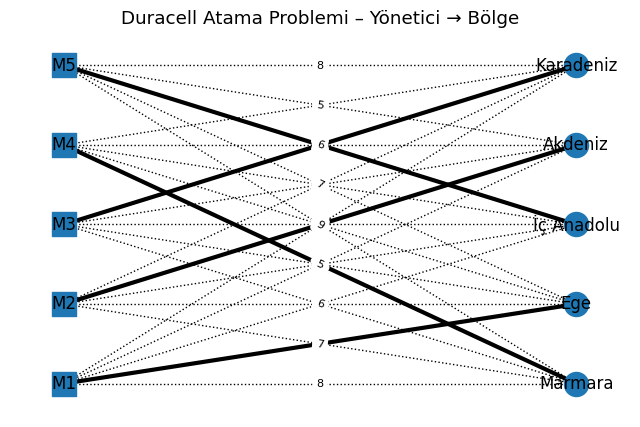

In [5]:
# %% [markdown]
# ## 4. Ağ (Network) Olarak Görselleştirme
# Sol tarafta yöneticiler, sağ tarafta bölgeler olacak şekilde iki kümeli bir grafik kuruyoruz.
# Atanan kenarları kalın ve farklı renkle gösteriyoruz.

# %%
G = nx.Graph()

# Node setleri
manager_nodes = [f"M{i+1}" for i in range(len(managers))]
region_nodes = regions

# Bipartite attribute ile ekleyelim
G.add_nodes_from(manager_nodes, bipartite=0, type="manager")
G.add_nodes_from(region_nodes, bipartite=1, type="region")

# Tüm kenarları maliyet etiketleriyle ekleyelim
for i, m in enumerate(managers):
    for j, r in enumerate(regions):
        G.add_edge(m, r, cost=cost_matrix[i, j])

# Pozisyonlar: sol yöneticiler, sağ bölgeler
pos = {}

# Sol (yöneticiler)
for i, m in enumerate(managers):
    pos[m] = (0, i)

# Sağ (bölgeler)
for j, r in enumerate(regions):
    pos[r] = (3, j)

# Kenar listeleri: atananlar vs atanamayanlar
assigned_edges = [(managers[r], regions[c]) for r, c in zip(row_ind, col_ind)]
other_edges = [e for e in G.edges() if e not in assigned_edges]

plt.figure()

# Önce tüm kenarları ince çizgiyle çiz
nx.draw_networkx_edges(G, pos, edgelist=other_edges, style="dotted")

# Atanan kenarları kalın çizgiyle çiz
nx.draw_networkx_edges(G, pos, edgelist=assigned_edges, width=3)

# Düğümler ve etiketler
nx.draw_networkx_nodes(G, pos, nodelist=manager_nodes, node_shape="s")
nx.draw_networkx_nodes(G, pos, nodelist=region_nodes, node_shape="o")
nx.draw_networkx_labels(G, pos)

# Kenar etiketleri (maliyetler)
edge_labels = {(u, v): d["cost"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.axis("off")
plt.title("Duracell Atama Problemi – Yönetici → Bölge")
plt.show()


In [7]:
# %% [markdown]
# ## 5. Özet
# - Kullanılan yöntem: Atama problemi (Hungarian algoritması).
# - Amaç: Toplam atama maliyetini minimize eden Yönetici-Bölge eşleşmelerini bulmak.
# - Çıktılar:
#     * `solution_df`: Her yöneticinin hangi bölgeye atandığı ve maliyetleri.
#     * `assignment_df`: 0-1 atama matrisi.
#     * Ağ grafiği: Çözümün görsel temsilini gösterir.
